In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

data1 = pd.read_excel(r"C:\Users\ADMIN\Downloads\DSTC V3\VNINDEX_cleaned.xlsx")
data1 = data1.drop("Unnamed: 0", axis =1)
data2 = pd.read_excel(r"C:\Users\ADMIN\Downloads\DSTC V3\HNXINDEX_cleaned.xlsx")
data2 = data2.drop("Unnamed: 0", axis =1)
data3 = pd.read_excel(r"C:\Users\ADMIN\Downloads\DSTC V3\UPCOM_cleaned.xlsx")
data3 = data3.drop("Unnamed: 0", axis =1)
data = pd.concat([data1, data2, data3], ignore_index=True)
data.info()

output_csv = r"C:\Users\ADMIN\Downloads\DSTC V3\AllIndex_cleaned.csv"
data.to_csv(output_csv, index=False)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 330513 entries, 0 to 330512
Data columns (total 23 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   exchange         330513 non-null  object 
 1   ticker           330513 non-null  object 
 2   timestamp        330513 non-null  object 
 3   open             330513 non-null  float64
 4   high             330513 non-null  float64
 5   low              330513 non-null  float64
 6   close            330513 non-null  float64
 7   volume           330513 non-null  int64  
 8   ema_50           330513 non-null  float64
 9   ema_200          330513 non-null  float64
 10  macd             330513 non-null  float64
 11  macd_signal      330513 non-null  float64
 12  macd_diff        330513 non-null  float64
 13  rsi              330513 non-null  float64
 14  bollinger_hband  330513 non-null  float64
 15  bollinger_lband  330513 non-null  float64
 16  mfi              330513 non-null  floa

In [70]:
def find_dynamic_thresholds(series, method="percentile", params=None):
   
    if method == "percentile":
        low_p = params.get("low", 10)   # mặc định 10th percentile
        high_p = params.get("high", 90) # mặc định 90th percentile
        lower = np.percentile(series, low_p)
        upper = np.percentile(series, high_p)
        
    elif method == "std":
        mean = series.mean()
        std = series.std()
        k = params.get("k", 1)  # mặc định ±1 std
        lower = mean - k * std
        upper = mean + k * std
        
    else:
        raise ValueError("method phải là 'percentile' hoặc 'std'")
    
    return lower, upper


In [71]:
def evaluate_thresholds(data, macd_col, return_col, thresholds):
    
    lower, upper = thresholds
    
    buy = data[data[macd_col] < lower][return_col].mean()
    sell = data[data[macd_col] > upper][return_col].mean()
    
    return {"buy_return": buy, "sell_return": sell}


In [72]:
results = []

for ex in data["exchange"].unique():
    data_ex = data[data["exchange"] == ex]
    
    # --- Phương pháp percentile ---
    lower, upper = find_dynamic_thresholds(data_ex["macd_diff"], 
                                           method="percentile", 
                                           params={"low": 10, "high": 90})
    perf = evaluate_thresholds(data_ex, "macd_diff", "return", (lower, upper))
    
    results.append({
        "exchange": ex,
        "method": "percentile",
        "lower": lower,
        "upper": upper,
        "buy_return": perf["buy_return"],
        "sell_return": perf["sell_return"]
    })
    
    # --- Phương pháp std ---
    lower, upper = find_dynamic_thresholds(data_ex["macd_diff"], 
                                           method="std", 
                                           params={"k": 1})
    perf = evaluate_thresholds(data_ex, "macd_diff", "return", (lower, upper))
    
    results.append({
        "exchange": ex,
        "method": "std",
        "lower": lower,
        "upper": upper,
        "buy_return": perf["buy_return"],
        "sell_return": perf["sell_return"]
    })

res_macd = pd.DataFrame(results)
res_macd


,exchange,method,lower,upper,buy_return,sell_return
0,VNINDEX,percentile,-190.806461,191.497498,-0.007960,0.007190
1,VNINDEX,std,-231.476007,232.031296,-0.008568,0.007481
2,HNXINDEX,percentile,-172.424148,176.457420,-0.010746,0.009104
3,HNXINDEX,std,-301.634857,300.145921,-0.014113,0.010812
4,UPCOM,percentile,-161.357601,163.167889,-0.007681,0.007763
5,UPCOM,std,-344.535983,340.622778,-0.008192,0.008752


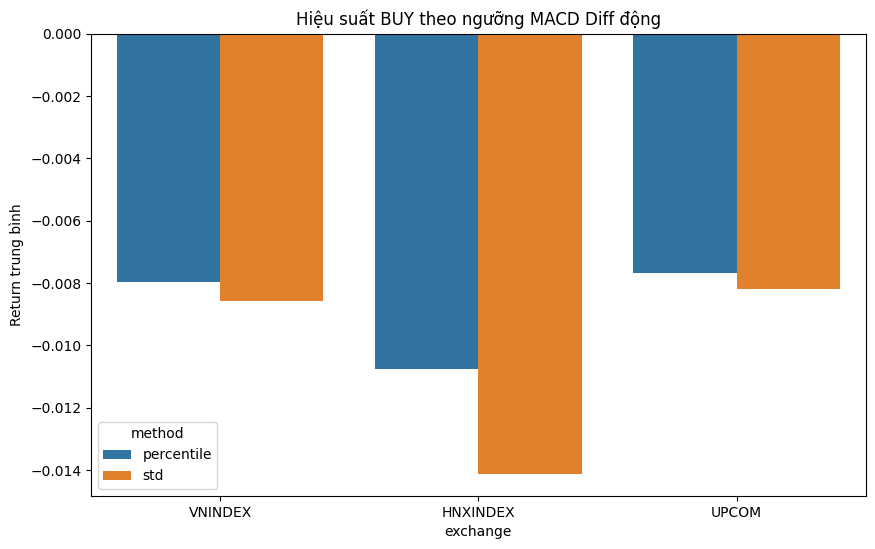

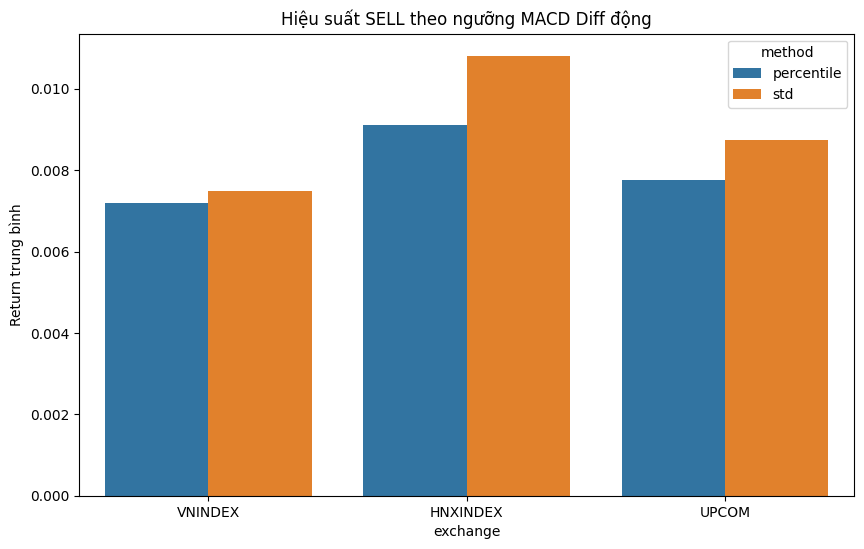

In [73]:
plt.figure(figsize=(10,6))
sns.barplot(data=res_macd, x="exchange", y="buy_return", hue="method")
plt.title("Hiệu suất BUY theo ngưỡng MACD Diff động")
plt.ylabel("Return trung bình")
plt.show()

plt.figure(figsize=(10,6))
sns.barplot(data=res_macd, x="exchange", y="sell_return", hue="method")
plt.title("Hiệu suất SELL theo ngưỡng MACD Diff động")
plt.ylabel("Return trung bình")
plt.show()


In [ ]:
import numpy as np

# Đảm bảo timestamp là datetime để sort
data['timestamp'] = pd.to_datetime(data['timestamp'])

# Hàm để tính các metrics backtest
def backtest_macd(data_ex, lower, upper, return_col='return'):
    # Sort theo thời gian
    data_ex = data_ex.sort_values('timestamp').copy()
    
    # Tạo signal: 1 nếu macd_diff < lower (buy/long), -1 nếu > upper (sell/short), 0 otherwise
    data_ex['signal'] = 0
    data_ex.loc[data_ex['macd_diff'] < lower, 'signal'] = 1
    data_ex.loc[data_ex['macd_diff'] > upper, 'signal'] = -1
    
    # Strategy returns: signal hôm trước * return hôm nay (hold overnight hoặc next period)
    data_ex['strategy_return'] = data_ex['signal'].shift(1) * data_ex[return_col]
    
    # Loại bỏ NaN (do shift)
    strategy_returns = data_ex['strategy_return'].dropna()
    
    if len(strategy_returns) == 0:
        return {
            'cumulative_return': np.nan,
            'sharpe_ratio': np.nan,
            'max_drawdown': np.nan
        }
    
    # Cumulative Return: (1 + returns).cumprod() - 1
    cum_prod = (1 + strategy_returns).cumprod()
    cumulative_return = cum_prod.iloc[-1] - 1
    
    # Sharpe Ratio: mean / std * sqrt(252) (giả sử daily data, annualized)
    mean_ret = strategy_returns.mean()
    std_ret = strategy_returns.std()
    sharpe_ratio = (mean_ret / std_ret) * np.sqrt(252) if std_ret != 0 else np.nan
    
    # Max Drawdown: max drop from peak
    peak = cum_prod.cummax()
    drawdown = (cum_prod - peak) / peak
    max_drawdown = drawdown.min()  # âm, càng âm càng tệ
    
    return {
        'cumulative_return': cumulative_return,
        'sharpe_ratio': sharpe_ratio,
        'max_drawdown': max_drawdown
    }

# Lấy thresholds từ res_macd (từ Cell 4)
# res_macd là DataFrame với columns: exchange, method, lower, upper, buy_return, sell_return

backtest_results = []

for idx, row in res_macd.iterrows():
    ex = row['exchange']
    method = row['method']
    lower = row['lower']
    upper = row['upper']
    
    data_ex = data[data['exchange'] == ex]
    
    metrics = backtest_macd(data_ex, lower, upper)
    
    backtest_results.append({
        'exchange': ex,
        'method': method,
        'lower': lower,
        'upper': upper,
        'cumulative_return': metrics['cumulative_return'],
        'sharpe_ratio': metrics['sharpe_ratio'],
        'max_drawdown': metrics['max_drawdown']
    })

res_backtest = pd.DataFrame(backtest_results)
res_backtest

# Chọn ngưỡng tối ưu cho từng sàn: dựa trên Sharpe Ratio cao nhất 
# Nếu Sharpe bằng nhau, chọn Cumulative Return cao hơn, hoặc Max Drawdown ít tệ hơn (ít âm hơn)

optimal_thresholds = res_backtest.loc[res_backtest.groupby('exchange')['sharpe_ratio'].idxmax()]
optimal_thresholds.reset_index(drop=True, inplace=True)

print("Ngưỡng tối ưu cho từng sàn (dựa trên Sharpe Ratio cao nhất):")
optimal_thresholds

Ngưỡng tối ưu cho từng sàn (dựa trên Sharpe Ratio cao nhất):


,exchange,method,lower,upper,cumulative_return,sharpe_ratio,max_drawdown
0,HNXINDEX,std,-301.634857,300.145921,-1.000000,-0.587686,-1.0
1,UPCOM,std,-344.535983,340.622778,-0.999999,-0.422086,-1.0
2,VNINDEX,std,-231.476007,232.031296,-1.000000,-0.647083,-1.0
